# Machine Learning Spam Classification using Transformers

Author: Bryan Lau

## Overview  

An application of machine learning for the classification of spam emails, using the popular Transformer model as outlined in Google's paper [Attention Is All You Need](https://doi.org/10.48550/arXiv.1706.03762) (Vaswan, et al., 2017).

Transformer models incorporate a mechanism described in the Google paper as Multi-Head Attention, that lets the model discover relationships between words throughout the text, without suffering from the short-term memory limitations that recurrent models such as RNN or LSTM models do (Vaswani, et al., 2017).  

Transformers are popularly used in a generative manner (e.g. ChatGPT), but I'll be using the model in a discriminative fashion here.

## Dataset  
I used the [Email Spam](https://www.kaggle.com/datasets/veleon/ham-and-spam-dataset) dataset from Kaggle, which contains about 3000 ham (legitimate) and spam emails. The data was split into training, validation and test sets.  

## Evaluation  
The performance of the model was evaluated based on its predictive accuracy against the test data, using common statistical metrics.

## Libraries

In [36]:
# Import required libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
import re
import seaborn as sns
import shutil
import time
import zipfile

## Definitions

Some global definitions that I used.

In [37]:
# The base directory containing the ham/spam emails
BASE_EMAILS_DIR = "./emails"

# The maximum permitted word length, based on the longest English 
# words likely to be encountered in general text (Eckler, 1996)
MAX_WORD_LEN = 22

# The ratio to split training/validation/test data
# This analysis will use a 70/15/15 split
TRAIN_DATA_SPLIT = 0.7
VALIDATION_DATA_SPLIT = 0.15

## Pre-Processing



### Unzipping the email data

First, the emails have to be unzipped. This creates two directories, `emails/ham` and `emails/spam`.

In [38]:
with zipfile.ZipFile("emails.zip", "r") as zf:
  zf.extractall(".")

### Reading the data from file

The next step is to read the text from the email files, so the format of the files needs to be understood.

A `formatString()` function is defined as a helper to format the strings that are read from the files:

In [39]:
###########################################################
# Function to format email strings
###########################################################
def formatString(str):

	# Remove special characters
	newstr = re.sub("[^a-zA-Z0-9 ]+", " ", str)

	# Remove newlines
	newstr = re.sub("\\r\\n", " ", newstr)

	# Remove repeated spaces
	newstr = re.sub(" +", " ", newstr)

	# Remove leading and trailing spaces
	newstr = newstr.strip()
	
	return newstr

Next, a `getEmailTextFromFile()` function is defined that  actually reads the data from the email text files.  In this function, the subject and body text are extracted individually, ignoring the remainder of the email headers that are present in the files.

I did consider including the headers as features, but in the end decided that they probably wouldn't have as much influence over the classification as the subject and body of the emails. Some experimentation along those lines might be interesting.

As part of this read process, extraneous characters are removed from the text. Some files also turned out to be encoded in ANSI rather than UTF-8, so that situation is handled here too.

In [40]:
###########################################################
# Read email text from file
###########################################################
def getEmailTextFromFile(filename):

	emailText = ""
	subject = ""
	body = ""

	# Open the file
	try:

		# Read using UTF-8 encoding
		with open(filename, "r", encoding="utf-8") as emailFile:
			emailText = emailFile.read()

	except UnicodeDecodeError:

		# Some files are encoded differently
		with open(filename, "r", encoding="latin-1") as emailFile:
			emailText = emailFile.read()

	# Extract the subject
	subjectStart = emailText.find("Subject: ") + 9
	subject = emailText[subjectStart : emailText.find("\n", subjectStart) ]

	# Extract the body
	body = emailText[emailText.find("\n\n") + 1 :]

	# Format the strings
	subject = formatString(subject)
	body = formatString(body)

	return subject, body

Next, the emails are ingested and parsed. The output is `allEmails` a list of dictionary email objects with the following structure:

|Field|Meaning|
|---|---|
|subject|Text from the email's subject line|
|body|Text from the email's body|
|type|The email's class, i.e. "ham" or "spam"|


In [41]:
# Initialize emails list
allEmails = []

# Initialize label classes
uniqueLabels = ["Ham", "Spam"]

# Formulate email directory paths
hamDir = os.path.join(BASE_EMAILS_DIR, "ham")
spamDir = os.path.join(BASE_EMAILS_DIR, "spam")

# Get email filenames
hamFilenames = os.listdir(hamDir)
spamFilenames = os.listdir(spamDir)

# Display the number of emails in each directory
print("There are %i ham files" % len(hamFilenames))
print("There are %i spam files" % len(spamFilenames))

# Read ham emails
for filename in hamFilenames:

	# Formulate email filename
	filename = os.path.join(hamDir, filename)

	# Read the subject and body from the file
	subject, body = getEmailTextFromFile(filename)
	
	# Create the email object
	email = { "subject": subject, "body": body, "type": "Ham" }

	# Add email to collection
	allEmails.append(email)

# Read spam emails
for filename in spamFilenames:

	# Formulate email filename
	filename = os.path.join(spamDir, filename)

	# Read the subject and body from the file
	subject, body = getEmailTextFromFile(filename)
	
	# Create the email object
	email = { "subject": subject, "body": body, "type": "Spam" }

	# Add email to collection
	allEmails.append(email)

print("Ingested", len(allEmails), "total email files")

There are 2551 ham files
There are 501 spam files
Ingested 3052 total email files


### Data Cleaning and Normalization

Next, I need a function to clean and normalize the data in preparation for splitting into training, validation and test sets.

### Randomization  
As a first step, the dataset is shuffled to randomize the order of the emails. This helps to ensure that there isn't any adverse influence if the emails are clustered or grouped in some way.  

### Cleaning  
To simplify the data and help to improve accuracy, the following actions are performed:

- The email subject is merged with the email body
- Stopwords are removed
- All words are lemmatized where necessary
- Unusually long words are removed

The subject and body text are assumed to be equally relevant to classifying the emails, and so they are merged into a single block of text for the purposes of analysis.

#### Stopwords  
Stopwords are filtered out of the email data using the list of stopwords from the NLTK library. These words don't  offer much lexical significance, so removing them helps with accuracy.

#### Lemmatization  
Since the text contains many different derivations of words, lemmatization is necessary in order to reduce the multitude of forms down to a common root word. This helps to improve the accuracy of the model.

#### Long Words  
While it is possible to have extremely long English words that exceed the threshold that I've chosen here, in practice it's unlikely to be the case, and so they're removed here. This has the side benefit of removing some long nonsense strings that are present in spam emails.  

The threshold of 20 letters was chosen based on the length of the longest English words likely to be encountered in common usage, as suggested in Making the Alphabet Dance (Eckler, 1996).

In [42]:
# Using the WordNet lemmatizer
wordLemmatizer = WordNetLemmatizer()

In [43]:
# Download some NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to D:\Projects\UoL\Natural
[nltk_data]     Language Processing\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to D:\Projects\UoL\Natural
[nltk_data]     Language Processing\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to D:\Projects\UoL\Natural
[nltk_data]     Language Processing\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [44]:
###########################################################
# Process the email data
#
# - Returns:
#     emailData: list of combined email subject and body
#     labelData: list of labels associated with emails
###########################################################
def processEmails(emails):

	# Define the email and label datasets
	emailData = []
	labelData = []

	# Shuffle the emails
	shuffledEmails = emails.copy()
	random.shuffle(shuffledEmails)

	# Process each email
	for email in shuffledEmails:

		# Merge the email subject and body text
		emailText = email["subject"] + " " + email["body"]

		# Make the text lowercase
		emailText = emailText.lower()

		# Tokenize and remove stopwords
		emailWordTokens = nltk.word_tokenize(emailText)
		emailText = [word for word in emailWordTokens if not word in stopwords.words("english")]

		# Remove words that are too long to be actual words
		emailText = [word for word in emailText if len(word) < MAX_WORD_LEN]

		# Apply lemmatizer
		emailText = [wordLemmatizer.lemmatize(word) for word in emailText]

		# Convert back to space delimited sentence
		emailText = " ".join(emailText)

		# Add the remaining words to the dataset
		emailData.append(emailText)

		# Extract the label for each email
		labelData.append(email["type"])

	# Return the emails and labels
	return emailData, labelData

In [45]:
# Process the emails that were read from the file
emailData, labelData = processEmails(allEmails)

It's a good idea to check a random sampling of the ingested emails to make sure that everything has worked fine so far.

In [46]:
# Display text and labels for some random emails
for i in range(4):
	sampleIndex = random.randint(0, len(emailData))
	numSampleChars = 100
	print("Combined subject and body for email #%i:\n '%s...'" % (sampleIndex, emailData[sampleIndex][:numSampleChars]))
	print(" This email is classified as: %s" % labelData[sampleIndex])
	print("")

Combined subject and body for email #314:
 'slaughter name god j justin mason jm jmason org writes j tibetan buddhism btw seem like awfully j ni...'
 This email is classified as: Ham

Combined subject and body for email #1723:
 'uk leading pc specialist nationwide pc repair upgrade call charge hourly charge picked home returned...'
 This email is classified as: Spam

Combined subject and body for email #2479:
 'ilug stop mlm insanity greeting receiving letter expressed interest receiving information online bus...'
 This email is classified as: Spam

Combined subject and body for email #1145:
 'recommended viewing g geege schuman geege barrera org writes g sure neurochemical process initiated ...'
 This email is classified as: Ham



It's also important to check the distribution of the labels in the dataset:

In [47]:
# Check for the distribution of the labels
labelDist = np.asarray(labelData)
allLabelDists = np.unique(labelDist, return_counts=True)
numItems = len(labelData)

# Print distribution ratio
print("The label distribution over the entire dataset is:")
print("  Ham: %.1f%%" % (allLabelDists[1][0] / numItems * 100))
print("  Spam: %.1f%%" % (allLabelDists[1][1] / numItems * 100))

The label distribution over the entire dataset is:
  Ham: 83.6%
  Spam: 16.4%


There are approximately five times more legitimate emails than spam ones, so the dataset is clearly not a balanced one.

I don't address the imbalance in this test, but there are data augmentation techniques that can address imbalanced classes like this, e.g. thesaurus, back translation, etc.

A severe imbalance has the potential to skew the model's accuracy, but I decided to go ahead with the current distribution and see how well it fared.

### Split the Data

OK so next the data is split into __training__, __validation__ and __test__ sets.

- The __training__ set is used to train the predictive model.
- The __validation__ is used to optimize the model during training.
- The __test__ set is used to evaluate the accuracy of the trained model's predictions.


In [48]:
# Split the data into training and test sets

# Calculate the size of the training set
numItems = len(emailData)
trainingSplitIndex = int(numItems * TRAIN_DATA_SPLIT)
validationSplitIndex = int(numItems * VALIDATION_DATA_SPLIT) + trainingSplitIndex

# Split training data
trainingData = emailData[:trainingSplitIndex]
trainingLabels = labelData[:trainingSplitIndex]

# Split validation data
validationData = emailData[trainingSplitIndex : validationSplitIndex]
validationLabels = labelData[trainingSplitIndex : validationSplitIndex]

# Split test data
testData = emailData[validationSplitIndex:]
testLabels = labelData[validationSplitIndex:]

# Display sizes
print("There are %i total emails" % numItems)
print("- There are %i items in the training set" % len(trainingData))
print("- There are %i items in the validation set" % len(validationData))
print("- There are %i items in the test set" % (len(testData)))

There are 3052 total emails
- There are 2136 items in the training set
- There are 457 items in the validation set
- There are 459 items in the test set


Since the random shuffling may result in a different ratio of ham/spam content in the individual training, validation and test datasets, it's best to examine the distribution in each individual set too.

In [49]:
# Summarize the label counts
trainingCounts = pd.DataFrame(trainingLabels, columns=["Training"]).groupby("Training").size()
validationCounts = pd.DataFrame(validationLabels, columns=["Validation"]).groupby("Validation").size()
testCounts = pd.DataFrame(testLabels, columns=["Test"]).groupby("Test").size()

# Merge the sets of counts together
labelDists = pd.concat([trainingCounts, validationCounts, testCounts], axis=1).transpose()
labelDists.rename(index={ 0: "Training", 1: "Validation", 2: "Test"}, inplace=True)

# Calculate the ham/spam ratio
labelDists["Spam %"] = round(labelDists["Spam"] / (labelDists["Ham"] + labelDists["Spam"]) * 100, 1)

labelDists

,Ham,Spam,Spam %
Training,1794,342,16.0
Validation,376,81,17.7
Test,381,78,17.0


In this run, at least, the variance of the ham-to-spam ratio in each individual set isn't large enough to be of concern.

### Vocabulary

Counting the number of unique words defines the size of the vocabulary.

In [50]:
# Determine the size of the vocabulary
# This will be based on the size of the training data only, since in theory 
# the model will have never seen either the validation or test data.
tempVocab = { "" }
for email in trainingData:
	for word in email.split(" "):
		tempVocab.add(word)
print("Training data has %i unique words" % len(tempVocab))

Training data has 34753 unique words


### Vectorize the Data

The model requires that the email text data be vectorized, or converted to numerical vector embeddings, prior to being used for training and validation.

In [51]:
# Set the maximum vocabulary size
MAX_VOCAB_SIZE = len(tempVocab)

# Instantiate vectorizer
vectorizer = tf.keras.layers.TextVectorization(max_tokens=MAX_VOCAB_SIZE)

# Adapt to the input text
vectorizer.adapt(emailData)
vectorizedEmailData = vectorizer(emailData)

# Split the vectorized input data
vectorizedTrainingData = vectorizedEmailData[:trainingSplitIndex]
vectorizedValidationData = vectorizedEmailData[trainingSplitIndex : validationSplitIndex]
vectorizedTestData = vectorizedEmailData[validationSplitIndex:]

# Get the maximum number of tokens for each email in the dataset
# This is used later to configure the embedding layer's dimensions
maxlen=len(vectorizedTrainingData[0])

# Display the sizes of the datasets for verification.
# They should match the non-vectorized dataset sizes.
print("There are %i total emails" % numItems)
print("- There are %i items in the vectorized training set (non-vectorized %i)" % (len(vectorizedTrainingData), len(trainingData)))
print("- There are %i items in the vectorized validation set (non-vectorized %i)" % (len(vectorizedValidationData), len(validationData)))
print("- There are %i items in the vectorized test set (non-vectorized %i)" % (len(vectorizedTestData), len(testData)))

There are 3052 total emails
- There are 2136 items in the vectorized training set (non-vectorized 2136)
- There are 457 items in the vectorized validation set (non-vectorized 457)
- There are 459 items in the vectorized test set (non-vectorized 459)


A similar conversion is applied to the training and validation labels.

In [52]:
# We'll also need to convert the binary labels to floats
encodedTrainingLabels = np.asarray([1.0 if label == "Ham" else 0.0 for label in trainingLabels])
encodedValidationLabels = np.asarray([1.0 if label == "Ham" else 0.0 for label in validationLabels])
encodedTestLabels = np.asarray([1.0 if label == "Ham" else 0.0 for label in testLabels])

### Create the Transformer  
Next the Transformer model is constructed. As mentioned previously this is a Transformer model using word embeddings and Multi-Head Attention, as described in the Google paper _Attention Is All You Need_ (Vaswani, et al., 2017).  

I dervied the practical implementation details from the Keras code examples page [Text Classification with Transformer](https://keras.io/examples/nlp/text_classification_with_transformer/) (Nandan, 2020), but I've added explanatory comments and expanded variable names for clarity.

The Transformer block is implemented as a separate layer class added to the model.

In [53]:
###########################################################
# Transformer layer
###########################################################
class TransformerBlock(tf.keras.layers.Layer):

    # Constructor
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()

        # Define Multi-Head Attention layer
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

        # Define dense layers
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )

        # Define normalization layers
        self.normalizedLayer1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.normalizedLayer2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        # Define dropout layers
        self.dropoutLayer1 = tf.keras.layers.Dropout(rate)
        self.dropoutLayer2 = tf.keras.layers.Dropout(rate)

    # Class instance can be called like a function
    def call(self, inputs, training):

        # Process Multi-Head Attention layer
        attentionLayerOutput = self.att(inputs, inputs)
        attentionLayerOutput = self.dropoutLayer1(attentionLayerOutput, training=training)

        # Apply layer normalization
        outputLayer1 = self.normalizedLayer1(inputs + attentionLayerOutput)

        # Process the feed forward dense layer
        denseLayerOutput = self.ffn(outputLayer1)
        denseLayerOutput = self.dropoutLayer2(denseLayerOutput, training=training)
        
        return self.normalizedLayer2(outputLayer1 + denseLayerOutput)

Unlike recurrent models such as RNN and LSTM which reference only recently seen data in the sequence, the Transformer model requires both embedded tokens as well as the position of the tokens in the text data.

This requires two separate embedding layers for these purposes, one for tokens and one for the position.

In [54]:
###########################################################
# Token Layer and Position Layer
###########################################################
class TokenAndPositionEmbedding(tf.keras.layers.Layer):

    # Constructor
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()

        # Initialize token layer
        self.tokenEmbeddings = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)

        # Initialize position layer
        self.positionalEmbeddings = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    # Class instance can be called like a function
    def call(self, x):

        # Embed the position
        maxlen = tf.shape(x)[-1]
        tokenPositions = tf.range(start=0, limit=maxlen, delta=1)
        tokenPositions = self.positionalEmbeddings(tokenPositions)

        # Embed the token
        x = self.tokenEmbeddings(x)

        # Return the positional embeddings
        return x + tokenPositions

Next the various layers are assembled to produce the complete Transformer model. This series of steps is likewise derived from _Text Classification with Transformer_ (Nandan, 2020), with variable names expanded for clarity.  

Unlike that example, however, the output layer in this implementation is reduced to one node and its activation function changed from `softmax` to `sigmoid`, in order to perform binary classification rather than multi-class.

In [55]:
# Parameters
EMBEDDING_DIM = 64  # Embedding size for each token
NUM_ATTENTION_HEADS = 2  # Number of attention heads
HIDDEN_LAYER_SIZE = 64  # Size of the Transformer's hidden layer
DROPOUT_RATE = 0.1 # Dropout layer rate

# Start with the input layer
inputs = tf.keras.layers.Input(shape=(maxlen,))

# Add the embedding layer
embeddingLayer = TokenAndPositionEmbedding(maxlen, MAX_VOCAB_SIZE, EMBEDDING_DIM)
modelLayer = embeddingLayer(inputs)

# Add the transformer block
transformerBlock = TransformerBlock(EMBEDDING_DIM, NUM_ATTENTION_HEADS, HIDDEN_LAYER_SIZE)
modelLayer = transformerBlock(modelLayer)

# Pooling layer
modelLayer = tf.keras.layers.GlobalAveragePooling1D()(modelLayer)
modelLayer = tf.keras.layers.Dropout(DROPOUT_RATE)(modelLayer)

# Dense layers
modelLayer = tf.keras.layers.Dense(20, activation="relu")(modelLayer)
modelLayer = tf.keras.layers.Dropout(DROPOUT_RATE)(modelLayer)

# Output layer
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(modelLayer)

# Assemble the Transformer model
xfModel = tf.keras.Model(inputs=inputs, outputs=outputs)

### Tuning and Compilation

To tune the performance of the model, the hyperparameters are adjusted over several training iterations.  

Specifically, the dimensions of the hidden layers and embedding sizes are each adjusted, with successive experiments resulting in small incremental improvements (around 1%) to the model's accuracy against the previously unseen data. Depending on hardware, training for each iteration can take quite some time.  

The model is compiled and a summary of the layers is displayed.

In [56]:
# Compile the model
xfModel.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'])

# Print the model summary
xfModel.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7635)]            0         
                                                                 
 token_and_position_embeddin  (None, 7635, 64)         2712832   
 g_1 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_1 (Transf  (None, 7635, 64)         41792     
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 64)                0   

An `EarlyStopping` callback class is defined to end the training early if the model stops improving over a defined (patience) number of epochs, i.e. to stop training if the validation loss is clearly not getting better over time.  

This is necessary since it's initially unclear how many epochs it would take for the validation loss to converge to a minimum, and once attained it would just be a waste of time to continue training epochs that don't return any significant improvement.  

The callback class provides another great benefit: the best model weights are retained if the training does end early.

In [57]:
# Define the EarlyStopping callback
xfModelCallback = tf.keras.callbacks.EarlyStopping(
	monitor="val_loss", 
	patience=3, 
	restore_best_weights=True,
	verbose=1
	)

## Train the Transformer Model  
The Transformer model is then trained using the vectorized data.  

In [58]:
# Number of epoch cycles to train
NUM_EPOCHS = 50

# Number of items to batch per epoch. Lower this if you encounter out of memory (OOM) issues
BATCH_SIZE = 10

# Record start time
startTimeXf = time.time()

# Train the model
historyXf = xfModel.fit(
	vectorizedTrainingData, 
	encodedTrainingLabels, 
	batch_size=BATCH_SIZE, 
	epochs=NUM_EPOCHS, 
	validation_data=(vectorizedValidationData, encodedValidationLabels),
	callbacks=[xfModelCallback])

print("Model training complete!\n")

# Display elapsed time
endTimeXf = time.time()
elapsedTimeXf = endTimeXf - startTimeXf
print("Elapsed training time: %.1fs (%.1f minutes)" % (elapsedTimeXf, elapsedTimeXf/60))

Epoch 1/50
214/214 [==============================] - 1919s 9s/step - loss: 0.4377 - accuracy: 0.8347 - val_loss: 0.4011 - val_accuracy: 0.8293
Epoch 2/50
214/214 [==============================] - 1918s 9s/step - loss: 0.1804 - accuracy: 0.9377 - val_loss: 0.0833 - val_accuracy: 0.9694
Epoch 3/50
214/214 [==============================] - 1918s 9s/step - loss: 0.0638 - accuracy: 0.9817 - val_loss: 0.0936 - val_accuracy: 0.9519
Epoch 4/50
214/214 [==============================] - 1963s 9s/step - loss: 0.0232 - accuracy: 0.9944 - val_loss: 0.0487 - val_accuracy: 0.9869
Epoch 5/50
214/214 [==============================] - 1969s 9s/step - loss: 0.0149 - accuracy: 0.9963 - val_loss: 0.0461 - val_accuracy: 0.9869
Epoch 6/50
214/214 [==============================] - 1968s 9s/step - loss: 0.0113 - accuracy: 0.9972 - val_loss: 0.0800 - val_accuracy: 0.9759
Epoch 7/50
214/214 [==============================] - 1967s 9s/step - loss: 0.0170 - accuracy: 0.9944 - val_loss: 0.0709 - val_accuracy:

Training on an AMD Ryzen 9 5900X 12-Core CPU and an NVIDIA GeForce RTX 2060 SUPER took almost 4.5 hours.

### Chart the Training Accuracy  

Once the model has been trained, the accuracy and loss across the training epochs can be charted.

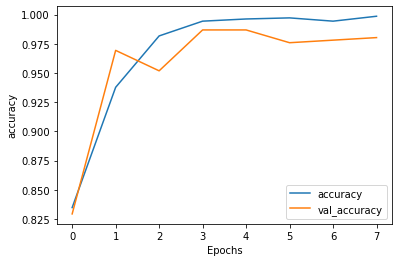

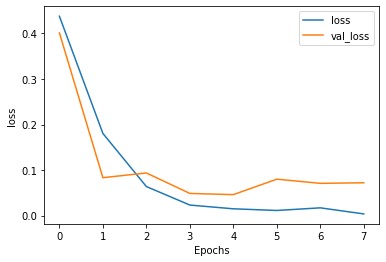

In [59]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss history
plot_graphs(historyXf, 'accuracy')
plot_graphs(historyXf, 'loss')

The validation accuracy closely follows the same trend as the training data, flattening out over time. This demonstrates a very slight loss of accuracy vs the training data, which is to be expected.

Similarly, the validation loss closely parallels the training loss, reaching optimum performance at epoch 5 (Note: the epochs are zero-indexed on the chart, so epoch 4 on the chart).

### Save the trained model

I saved the trained model weights in case I wanted to play around with predictions later, without having to go through the whole training process all over again.

In [60]:
# The saved model name
modelName = "xf_spam_classifier"

In [ ]:
# Save the model
xfModel.save("./" + modelName)

# Archive the model folder
shutil.make_archive(modelName, "zip", modelName)

The loading function is only used if I'm resuming from another session.

In [62]:
# Load the trained model
def load_saved_model(modelName):

  # Unzip the trained model 
  with zipfile.ZipFile("./" + modelName + ".zip", "r") as zf:
    zf.extractall("./" + modelName)
  
  return tf.keras.models.load_model(modelName)

In [63]:
# Load saved model if resuming
#xfModel = load_saved_model(modelName)

### Calculate the Model's Scores

Now to calculate the model's performance metrics.

As a first step, a set of label predictions is made against the previously unseen email data contained in the test dataset.

In [64]:
# Generate predictions using the Transformer
xfPredictedLabels = xfModel.predict(vectorizedTestData)

# Convert probabilistic values to text labels
xfPredictedLabels = ["Ham" if label >= 0.5 else "Spam" for label in xfPredictedLabels]

15/15 [==============================] - 734s 26s/step


These predictions are then compared against the actual labels to calculate the various performance scores.

This is a function to calculate the most common scores, namely accuracy, precision, recall and F1.

In [65]:
###########################################################
# Calculate model scores
###########################################################
def calculateModelScores(actualLabels, predictedLabels):

	# Calculate the scores
	accuracyScore = accuracy_score(actualLabels, predictedLabels)
	precisionScore = precision_score(actualLabels, predictedLabels, pos_label="Ham", average="binary")
	recallScore = recall_score(actualLabels, predictedLabels, pos_label="Ham", average="binary")
	f1Score = f1_score(actualLabels, predictedLabels, pos_label="Ham", average="binary")

	return accuracyScore, precisionScore, recallScore, f1Score

In [66]:
# Calculate the scores for the target model
xfAccuracy, xfPrecision, xfRecall, xfF1 = calculateModelScores(testLabels, xfPredictedLabels)

In [67]:
# Display the model scores
print("Model Accuracy:", round(xfAccuracy, 2))
print("Model Precision:", round(xfPrecision, 2))
print("Model Recall:", round(xfRecall, 2))
print("Model F1:", round(xfF1, 2))

Model Accuracy: 0.99
Model Precision: 0.99
Model Recall: 0.99
Model F1: 0.99


These are excellent scores, but even if there was more variation in the metrics, the F1 score would be particularly relevant here due to the imbalance in the data set.

### Analyze Errors

We can also use the results to analyze the nature of the prediction errors using a confusion matrix.

The model achieved an accuracy of 98.9%


Text(91.68, 0.5, 'Predicted Labels')

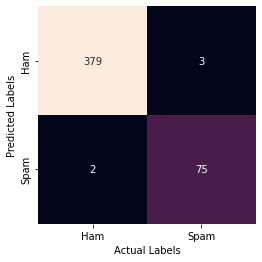

In [68]:
# Display the accuracy
print("The model achieved an accuracy of %.1f%%" % (xfAccuracy * 100))

# Generate the confusion matrix
xfConfusionMatrix = confusion_matrix(testLabels, xfPredictedLabels)

# Extract the matrix componenets
xfTN, xfFP, xfFN, xfTP = xfConfusionMatrix.ravel()

# Visualize the performance
sns.heatmap(xfConfusionMatrix.T, square=True, annot=True, fmt="d", cbar=False, xticklabels=uniqueLabels, yticklabels=uniqueLabels)
plt.xlabel("Actual Labels")
plt.ylabel("Predicted Labels")

From the confusion matrix, it's obvious that the model made very few prediction errors overall.

In [70]:
# Display model statistics and error rates
print("The accuracy was %.2f" % xfAccuracy)
print("- This indicates how often the model makes correct predictions.\n")

print("The precision was %.2f" % xfPrecision)
print("- This is a measure of the model's ability to avoid classifying a spam email as legitimate.\n")

print("The recall was %.2f" % xfRecall)
print("- This is a measure of the model's ability to detect legitimate emails.\n")

print("The F1 score was %.2f" % xfF1)
print("- This is another measure of the model's accuracy. It can be more reliable in situations where the dataset is imbalanced.\n")

print("There were %i false positives and %i false negatives.\n" % (xfFP, xfFN))

xfMistaken = (xfFP + xfFN) / len(testData) * 100
print("Model was mistaken in %.1f%% of cases." % xfMistaken)

The accuracy was 0.99
- This indicates how often the model makes correct predictions.

The precision was 0.99
- This is a measure of the model's ability to avoid classifying a spam email as legitimate.

The recall was 0.99
- This is a measure of the model's ability to detect legitimate emails.

The F1 score was 0.99
- This is another measure of the model's accuracy. It can be more reliable in situations where the dataset is imbalanced.

There were 2 false positives and 3 false negatives.

Model was mistaken in 1.1% of cases.


An excellent result! The model was only mistaken __1.1%__ of the time against the test dataset. In other words, this model correctly classified 99 out of every 100 emails based on predictions against previously unseen data.

This margin of error could possibly be further improved by additional tuning of the hyperparameters, or possibly applying data augmentation to the class imbalance disparity noted earlier.

## Conclusion

When applied towards the task of classifying previously unseen ham and spam emails, the Transformer model appears to perform exceptionally well. It requires a significant amount of time for training vs a simpler model--such as Multinomial Naive Bayes for example--but its particular characteristics and Multi-Head Attention mechanism allowed for very effective discrimination between samples.  